In [25]:
from models import LSTMModel
import torch
import lightning
import utils
import numpy as np


In [26]:
model = LSTMModel.load_from_checkpoint("reports/lstm-logs/LSTM-seq_len=100 hidden_size=32 num_layer=1/checkpoints/epoch=26-step=918.ckpt", map_location={"cuda:0": "cpu"})
# model = LSTMModel.load_from_checkpoint("lstm-logs/LSTM-seq_len=10 hidden_size=16 num_layer=1/checkpoints/epoch=39-step=1480.ckpt", map_location={"cuda:0": "cpu"})
model


LSTMModel(
  (lstm): LSTM(4, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
  (criterion): MSELoss()
)

In [27]:
import pandas as pd

# SEQ_LENGTH = 10
SEQ_LENGTH = 100

df_train, df_test, df_valid, mu, std = utils.load_cleaned_data()

df_concatenated = pd.concat([df_valid, df_train])
df_test_extended = pd.concat([df_concatenated.iloc[-SEQ_LENGTH:], df_test])


Mean Squared Error: 18.49641702652512
Root Mean Squared Error: 4.300746101146302


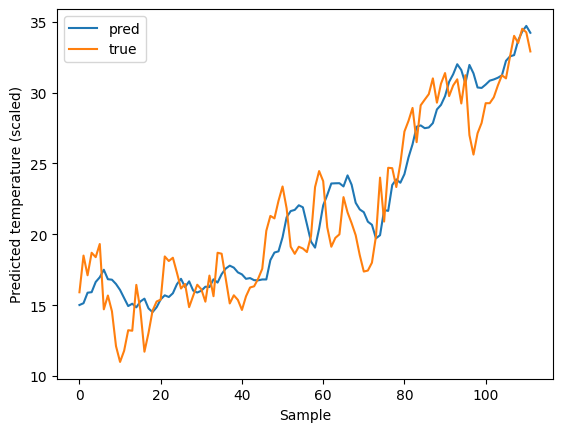

In [28]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error


dataloader_test = torch.utils.data.DataLoader(utils.ClimateDataset(df_test_extended, SEQ_LENGTH), batch_size=1, shuffle=False, num_workers=15)

preds, true = model.predict(dataloader_test)

preds = preds * std.to_numpy() + mu.to_numpy()
true = true * std.to_numpy() + mu.to_numpy()


true = true.reshape(true.shape[0], true.shape[-1])
preds = preds.reshape(preds.shape[0], preds.shape[-1])

mse = mean_squared_error(true, preds)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", np.sqrt(mse))
plt.plot(preds[:,0], label="pred")
plt.plot(true[:,0], label="true")
plt.xlabel('Sample')
plt.ylabel('Predicted temperature (scaled)')
plt.legend()
plt.show()


In [29]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error


dataloader_test = torch.utils.data.DataLoader(utils.ClimateDataset(df_test_extended, SEQ_LENGTH), batch_size=1, shuffle=False, num_workers=15)

x = torch.tensor(df_concatenated.iloc[-SEQ_LENGTH:].to_numpy().astype(np.float32)).unsqueeze(0)

preds = model.autoregressive_predict(x, df_test.shape[0])
preds = np.array(preds)




Mean Squared Error: 19.47552406472086
Root Mean Squared Error: 4.41310820904279


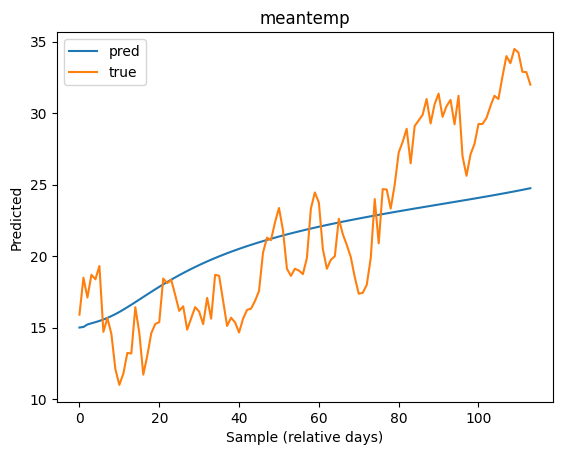

Mean Squared Error: 284.2223834506856
Root Mean Squared Error: 16.85889627023921


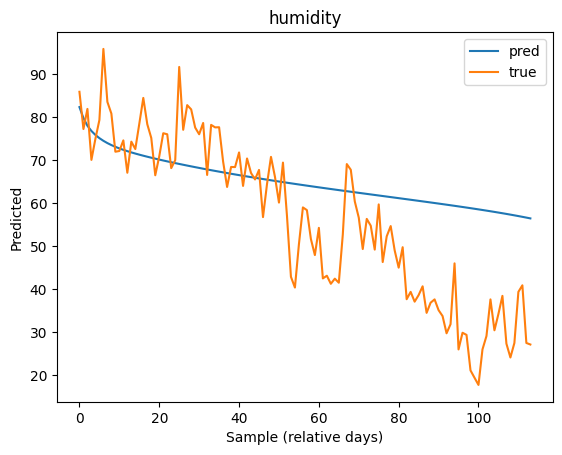

Mean Squared Error: 12.299704061495667
Root Mean Squared Error: 3.507093392183286


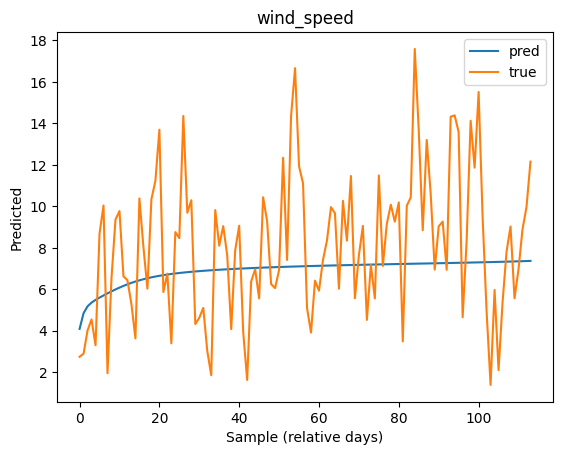

Mean Squared Error: 23.913841569021056
Root Mean Squared Error: 4.890178071299761


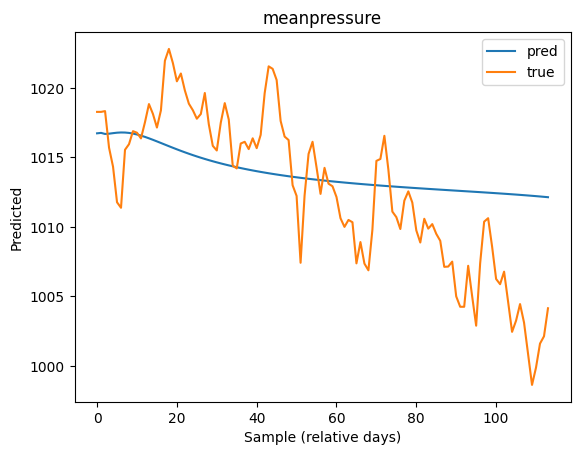

In [30]:

true = df_test.to_numpy()
preds = preds.reshape(preds.shape[0], preds.shape[-1])

preds = preds * std.to_numpy() + mu.to_numpy()
true = true * std.to_numpy() + mu.to_numpy()



for i, name in enumerate(df_test.columns):
    mse = mean_squared_error(true[:,i], preds[:,i])
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", np.sqrt(mse))
    plt.plot(preds[:,i], label="pred")
    plt.plot(true[:,i], label="true")
    plt.xlabel('Sample (relative days)')
    plt.ylabel(f'Predicted')
    plt.title(name)
    plt.legend()
    plt.show()


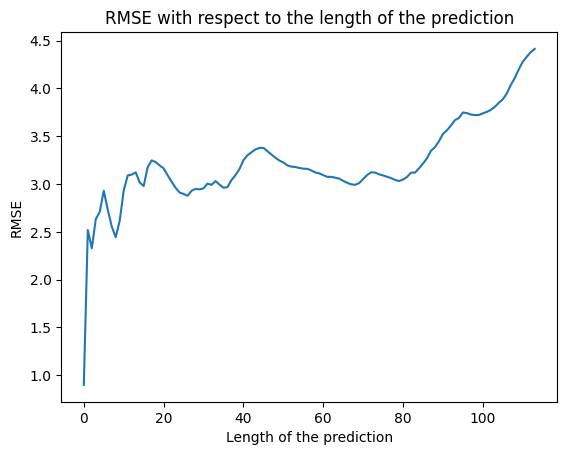

In [31]:
true_t = true[:,0]
preds_t = preds.reshape(preds.shape[0], preds.shape[-1])[:,0]

rmses = []
for i in range(1, true_t.shape[-1]+1):
    mse = mean_squared_error(true_t[:i], preds_t[:i])
    rmse = np.sqrt(mse)
    rmses.append(rmse)

plt.title("RMSE with respect to the length of the prediction")
plt.plot(rmses)
plt.xlabel("Length of the prediction")
plt.ylabel("RMSE")
plt.show()